In [1]:
import torch
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import argparse,os,time
from torch import Tensor
from typing import Type, Any, Callable, Union, List, Optional
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
mean=np.load('mean.npy').tolist()
std=np.load('std.npy').tolist()
mean_test=np.load('mean_test_30000.npy').tolist()
std_test=np.load('std_test_30000.npy').tolist()

In [3]:
class CustomDataset(Dataset):
    def __init__(self,path):
        xy = np.loadtxt(path,
                        delimiter=',', dtype=np.float32)
        self.len = xy.shape[0]
        self.x_data = torch.tensor(xy[:, 0:5])
        xy=xy.astype('int_')
        self.y_data = torch.tensor(xy[:, 5])

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [4]:
batch_size=300
lr=0.001

num_layers=[2,2,2]
_nodes=[40,20,60]

train_dataset = CustomDataset('norm_data_train_uniform_ext.csv')
train_loader = DataLoader(dataset=train_dataset,pin_memory=True,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=60,drop_last=True)
test_dataset = CustomDataset('norm_data_test_uniform_ext_30000.csv')
test_loader = DataLoader(dataset=test_dataset,pin_memory=True,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=60,drop_last=True)

In [5]:
class FClayer(nn.Module):
    def __init__(self, innodes: int, nodes: int):
        super(FClayer, self).__init__()
        self.fc=nn.Linear(innodes,nodes)
        self.act=nn.LeakyReLU(0.2, inplace=True)
    def forward(self, x: Tensor) -> Tensor:
        out=self.fc(x)
        out=self.act(out)
        return out

In [6]:
class WaveNET(nn.Module):
    def __init__(self, block: Type[Union[FClayer]], planes: List[int], nodes: List[int], num_classes: int = 3
                ) -> None:
        super(WaveNET, self).__init__()
        self.innodes=5
        
        self.layer1=self._make_layer(block, planes[0], nodes[0])
        self.layer2=self._make_layer(block, planes[1], nodes[1])
        self.layer3=self._make_layer(block, planes[2], nodes[2])
        
        self.fin_fc=nn.Linear(self.innodes,num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    
    def _make_layer(self, block: Type[Union[FClayer]], planes: int, nodes: int) -> nn.Sequential:

        layers = []
        layers.append(block(self.innodes, nodes))
        self.innodes = nodes
        for _ in range(1, planes):
            layers.append(block(self.innodes, nodes))

        return nn.Sequential(*layers)

        
    def _forward_impl(self, x: Tensor) -> Tensor:
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fin_fc(x)
        
        return x
    
    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [7]:
def Model(block, planes, **kwargs):
    model = WaveNET(block, planes, **kwargs)
    return model

In [8]:
model=WaveNET(FClayer,num_layers,_nodes).cuda()

In [9]:
from torchsummary import summary
summary(model,(1,5))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 40]             240
         LeakyReLU-2                [-1, 1, 40]               0
           FClayer-3                [-1, 1, 40]               0
            Linear-4                [-1, 1, 40]           1,640
         LeakyReLU-5                [-1, 1, 40]               0
           FClayer-6                [-1, 1, 40]               0
            Linear-7                [-1, 1, 20]             820
         LeakyReLU-8                [-1, 1, 20]               0
           FClayer-9                [-1, 1, 20]               0
           Linear-10                [-1, 1, 20]             420
        LeakyReLU-11                [-1, 1, 20]               0
          FClayer-12                [-1, 1, 20]               0
           Linear-13                [-1, 1, 60]           1,260
        LeakyReLU-14                [-1

In [10]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30)

In [11]:
saving_path="./"
trn_loss_list = []
val_loss_list = []
val_acc_list = []
total_epoch=120
model_char="fin"
model_name=""
patience=10
start_early_stop_check=0
saving_start_epoch=10

for epoch in range(total_epoch):
    trn_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs=inputs.cuda()
            labels=labels.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        output= model(inputs)
        # calculate loss
        loss=criterion(output, labels)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        # del (memory issue)
        del loss
        del output
    with torch.no_grad():
        val_loss = 0.0
        cor_match = 0
        for j, val in enumerate(test_loader):
            val_x, val_label = val
            if torch.cuda.is_available():
                val_x = val_x.cuda()
                val_label =val_label.cuda()
            val_output = model(val_x)
            v_loss = criterion(val_output, val_label)
            val_loss += v_loss
            _, predicted=torch.max(val_output,1)
            cor_match+=np.count_nonzero(predicted.cpu().detach()==val_label.cpu().detach())
    del val_output
    del v_loss
    del predicted
    
    scheduler.step()
    
    
    
    trn_loss_list.append(trn_loss/len(train_loader))
    val_loss_list.append(val_loss/len(test_loader))
    val_acc=cor_match/(len(test_loader)*batch_size)
    val_acc_list.append(val_acc)
    now = time.localtime()
    print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))

    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | val accuracy: {:.4f}% \n".format(
                epoch+1, total_epoch, trn_loss / len(train_loader), val_loss / len(test_loader), val_acc*100
            ))
    
    
#     if epoch+1>2:
#         if val_loss_list[-1]>val_loss_list[-2]:
#             start_early_stop_check=1
#     else:
#         val_loss_min=val_loss_list[-1]
        
#     if start_early_stop_check:
#         early_stop_temp=val_loss_list[-patience:]
#         if all(early_stop_temp[i]<early_stop_temp[i+1] for i in range (len(early_stop_temp)-1)):
#             print("Early stop!")
#             break
            
#     if epoch+1>saving_start_epoch:
#         if val_loss_list[-1]<val_loss_min:
#             if os.path.isfile(model_name):
#                 os.remove(model_name)
#             val_loss_min=val_loss_list[-1]
#             model_name=saving_path+"Custom_model_"+model_char+"_{:.3f}".format(val_loss_min)
#             torch.save(model, model_name)
#             print("Model replaced and saved as ",model_name)

2020/12/01 02:46:10
epoch: 1/120 | trn loss: 0.1197 | val loss: 0.0593 | val accuracy: 98.5333% 

2020/12/01 02:46:22
epoch: 2/120 | trn loss: 0.0491 | val loss: 0.0505 | val accuracy: 98.2467% 

2020/12/01 02:46:33
epoch: 3/120 | trn loss: 0.0431 | val loss: 0.0547 | val accuracy: 98.2733% 

2020/12/01 02:46:45
epoch: 4/120 | trn loss: 0.0401 | val loss: 0.0455 | val accuracy: 98.5300% 

2020/12/01 02:46:57
epoch: 5/120 | trn loss: 0.0390 | val loss: 0.0392 | val accuracy: 98.7933% 

2020/12/01 02:47:09
epoch: 6/120 | trn loss: 0.0383 | val loss: 0.0355 | val accuracy: 98.9467% 

2020/12/01 02:47:20
epoch: 7/120 | trn loss: 0.0360 | val loss: 0.0399 | val accuracy: 98.6867% 

2020/12/01 02:47:32
epoch: 8/120 | trn loss: 0.0349 | val loss: 0.0334 | val accuracy: 99.0000% 

2020/12/01 02:47:44
epoch: 9/120 | trn loss: 0.0345 | val loss: 0.0388 | val accuracy: 98.7200% 

2020/12/01 02:47:56
epoch: 10/120 | trn loss: 0.0344 | val loss: 0.0451 | val accuracy: 98.4933% 

2020/12/01 02:48:08

2020/12/01 03:02:10
epoch: 84/120 | trn loss: 0.0104 | val loss: 0.0411 | val accuracy: 98.3400% 

2020/12/01 03:02:21
epoch: 85/120 | trn loss: 0.0104 | val loss: 0.0363 | val accuracy: 98.5467% 

2020/12/01 03:02:32
epoch: 86/120 | trn loss: 0.0104 | val loss: 0.0386 | val accuracy: 98.4267% 

2020/12/01 03:02:44
epoch: 87/120 | trn loss: 0.0104 | val loss: 0.0414 | val accuracy: 98.3733% 

2020/12/01 03:02:56
epoch: 88/120 | trn loss: 0.0104 | val loss: 0.0382 | val accuracy: 98.5233% 

2020/12/01 03:03:07
epoch: 89/120 | trn loss: 0.0104 | val loss: 0.0403 | val accuracy: 98.3933% 

2020/12/01 03:03:18
epoch: 90/120 | trn loss: 0.0104 | val loss: 0.0420 | val accuracy: 98.3367% 

2020/12/01 03:03:30
epoch: 91/120 | trn loss: 0.0103 | val loss: 0.0397 | val accuracy: 98.4067% 

2020/12/01 03:03:42
epoch: 92/120 | trn loss: 0.0103 | val loss: 0.0396 | val accuracy: 98.4267% 

2020/12/01 03:03:54
epoch: 93/120 | trn loss: 0.0103 | val loss: 0.0398 | val accuracy: 98.4000% 

2020/12/01

In [12]:
model_name=saving_path+"Custom_model_"+model_char
torch.save(model, model_name)

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type WaveNET. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type FClayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [13]:
target_temp=np.zeros(1)
output_temp=np.zeros(1)
input_temp=np.zeros((1,5))
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        _, predicted=torch.max(output,1)
        target_temp=np.hstack([target_temp,target.cpu().numpy()])
        output_temp=np.hstack([output_temp,predicted.cpu().numpy()])
        input_temp=np.vstack([input_temp,data.cpu().numpy()])
target_temp=np.delete(target_temp,0)
output_temp=np.delete(output_temp,0)
input_temp=np.delete(input_temp,0,axis=0)

In [14]:
correct = 0
for i in range(len(output_temp)):
    correct += (output_temp[i] == target_temp[i])

print('Accuracy of the network: %d %%' % (
    100 * correct /len(output_temp)))

Accuracy of the network: 98 %


In [15]:
correct_d=0
tot_d=0
correct_u=0
tot_u=0
correct_s=0
tot_s=0
for i in range(len(output_temp)):
    if(target_temp[i]==1):
        correct_d += (output_temp[i] == target_temp[i])
        tot_d += 1
        
    if(target_temp[i]==0):
        correct_s += (output_temp[i] == target_temp[i])
        tot_s += 1
        
    if(target_temp[i]==2):
        correct_u += (output_temp[i] == target_temp[i])
        tot_u += 1

print('Accuracy of the network control down: %d %%' % (
    100 * correct_d /tot_d))
print('Accuracy of the network control stay: %d %%' % (
    100 * correct_s /tot_s))
print('Accuracy of the network control up: %d %%' % (
    100 * correct_u /tot_u))

Accuracy of the network control down: 97 %
Accuracy of the network control stay: 98 %
Accuracy of the network control up: 98 %


In [16]:
con_mat=np.zeros((3,3))
con_mat[0,0]

0.0

[[9791.  209.    0.]
 [  68. 9889.   43.]
 [ 138.   20. 9842.]]


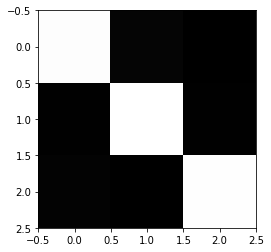

In [17]:
con_mat=np.zeros((3,3))
con_mat2=np.zeros((2,2))
tot_d=0
tot_u=0
tot_s=0
err_idx=[]
stay_err=[]
for i in range(len(output_temp)):
    if(target_temp[i]==1):
        tot_d += 1
        if (output_temp[i]==1):
            con_mat[0,0]+=1
        if (output_temp[i]==0):
            con_mat[0,1]+=1
            err_idx.append(i)
            stay_err.append(i)
        if (output_temp[i]==2):
            con_mat[0,2]+=1
            err_idx.append(i)
        
    if(target_temp[i]==0):
        tot_s += 1
        if (output_temp[i]==1):
            con_mat[1,0]+=1
            err_idx.append(i)
        if (output_temp[i]==0):
            con_mat[1,1]+=1
        if (output_temp[i]==2):
            con_mat[1,2]+=1
            err_idx.append(i)
        
    if(target_temp[i]==2):
        tot_u += 1
        if (output_temp[i]==1):
            con_mat[2,0]+=1
            err_idx.append(i)
        if (output_temp[i]==0):
            con_mat[2,1]+=1
            err_idx.append(i)
            stay_err.append(i)
        if (output_temp[i]==2):
            con_mat[2,2]+=1
        
plt.imshow(con_mat,cmap="gray")
print(con_mat)
con_mat2[0,0]=np.sum(con_mat[0:3:2,0:3:2])
con_mat2[0,1]=np.sum(con_mat[0:3:2,1])
con_mat2[1,0]=np.sum(con_mat[1,0:3:2])
con_mat2[1,1]=np.sum(con_mat[1,1])

In [18]:
torch.save(model.state_dict(), "train_res")

In [19]:
con_mat

array([[9791.,  209.,    0.],
       [  68., 9889.,   43.],
       [ 138.,   20., 9842.]])

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=None):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(int(cm[i, j])),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

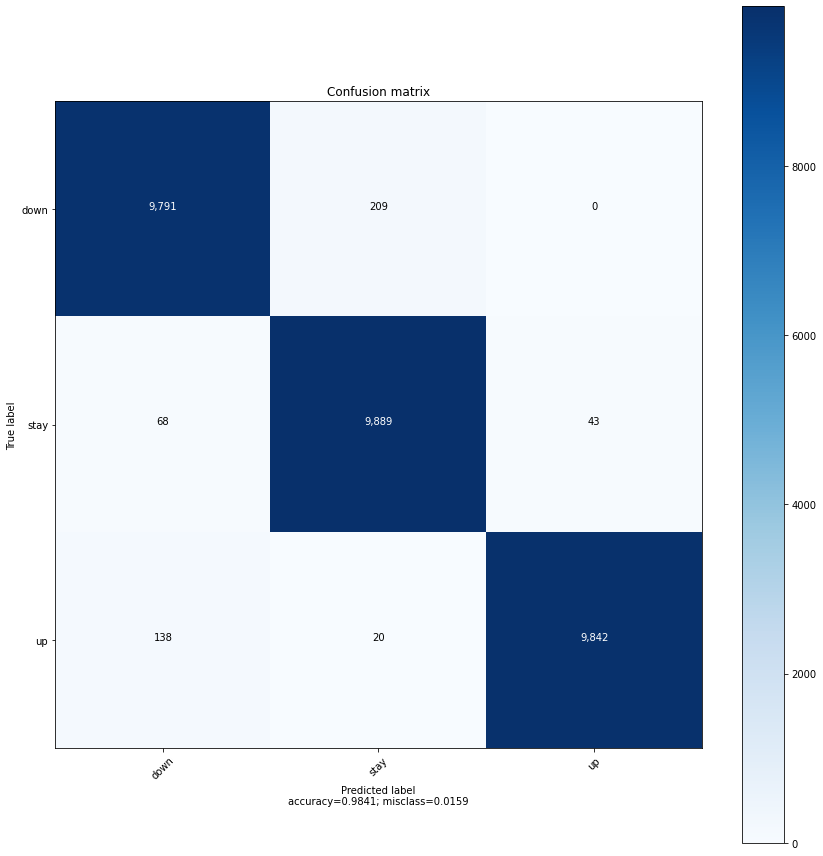

In [21]:
plot_confusion_matrix(con_mat,['down','stay','up'])

In [22]:
# overall err
error=[]
for idx in err_idx:
    error.append(input_temp[idx])
error=np.array(error)*std_test+mean_test
error_df=pd.DataFrame(error, columns=['r','vc','los','daz','dlos'])
pd.set_option('display.max_rows', None)
error_df

,r,vc,los,daz,dlos
0,3181.361041,370.730221,0.031013,-0.004181,0.008019
1,2225.812017,399.172236,0.044775,0.006950,0.016753
2,3744.957670,398.967459,-0.001634,-0.001847,-0.000172
3,2809.603353,383.664989,0.035577,-0.004067,0.012447
4,3512.386648,392.964701,-0.000302,-0.002503,-0.000894
5,3308.852082,382.054021,0.029933,-0.001526,0.007494
6,3267.007258,399.557310,0.030078,0.001801,0.010198
7,2877.420478,397.089715,0.023221,0.005194,0.003179
8,3595.765008,397.175805,-0.000233,-0.002267,-0.000480
9,2134.345437,383.612857,-0.008389,0.009278,-0.001462


In [23]:
error_df.to_csv("overall_error_df.csv", mode='w')

In [24]:
# stay err
error=[]
for idx in stay_err:
    error.append(input_temp[idx])
error=np.array(error)*std_test+mean_test
error_df=pd.DataFrame(error, columns=['r','vc','los','daz','dlos'])
pd.set_option('display.max_rows', None)
error_df

,r,vc,los,daz,dlos
0,3181.361041,370.730221,0.031013,-0.004181,0.008019
1,2225.812017,399.172236,0.044775,0.006950,0.016753
2,2809.603353,383.664989,0.035577,-0.004067,0.012447
3,3308.852082,382.054021,0.029933,-0.001526,0.007494
4,3267.007258,399.557310,0.030078,0.001801,0.010198
5,2233.419371,384.525030,0.044757,-0.011997,0.016458
6,3391.868238,396.490623,0.028848,0.003525,0.006282
7,2060.341625,397.894334,0.048242,0.004661,0.018756
8,3162.705285,371.072074,0.030803,0.003948,0.006977
9,334.732596,373.367236,0.297975,-0.177300,0.281361


In [25]:
with torch.no_grad():
    cor_match = 0
    for j, trn in enumerate(train_loader):
        trn_x, trn_label = trn
        if torch.cuda.is_available():
            trn_x = trn_x.cuda()
            trn_label =trn_label.cuda()
        trn_output = model(trn_x)
        _, predicted=torch.max(trn_output,1)
        cor_match+=np.count_nonzero(predicted.cpu().detach()==trn_label.cpu().detach())
del trn_output
del predicted
trn_acc=cor_match/(len(train_loader)*batch_size)

print("Train accuracy: {:.4f}".format(trn_acc))

Train accuracy: 0.9965


In [26]:
error_df.to_csv("stay_error_df.csv", mode='w')